In [1]:
!pip install -q transformers
!pip install pydot
!pip install -U scikit-learn
!pip install datasets
!pip install ipynb
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from datasets import load_dataset
from transformers import DebertaTokenizer, TFDebertaModel, TFRobertaForSequenceClassification, RobertaTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataset = load_dataset('parquet', data_files={'train': ['/content/drive/MyDrive/w266 Final project/yelp_review_trainset_subset_3_cls.parquet'],
                        'test': '/content/drive/MyDrive/w266 Final project/yelp_review_testset_subset_3_cls.parquet'})

train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


display(len(train_labels), len(test_labels))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

1700

300

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'word_count', '__index_level_0__'],
        num_rows: 1700
    })
    test: Dataset({
        features: ['label', 'text', 'word_count', '__index_level_0__'],
        num_rows: 300
    })
})

## RoBERTa-base

In [4]:
### Hyperparams for roberta
num_classes = 3
hidden_size = 100
dropout = 0.2
learning_rate = 1e-5
max_length = 200
epoch = 3

In [5]:
# tokenization
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
roberta_train_encodings = roberta_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
roberta_test_encodings = roberta_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
nptest_labels = np.asarray(test_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification

In [6]:
def create_roberta_multiclass_model(checkpoint = model,
                                 num_classes = 5,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                 max_length = 200):

    # Input Preparations
    roberta_input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    roberta_attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': roberta_input_ids,
            'attention_mask': roberta_attention_mask}

    # Roberta
    roberta_out = model(roberta_input_ids, output_hidden_states=True)

    # Pooler Token
    pooler_token = roberta_out.hidden_states[-1]
    pooler_token = pooler_token[:,0]

    # Hidden Layers
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Classification Layers
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[roberta_input_ids, roberta_attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                metrics='accuracy')

    return classification_model

In [7]:
pooler_roberta_model = create_roberta_multiclass_model(checkpoint=model,num_classes=num_classes,hidden_size=hidden_size,dropout=dropout,learning_rate=learning_rate,max_length=max_length)
# pooler_roberta_model.summary()
# keras.utils.plot_model(pooler_roberta_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)
# training
pooler_roberta_model_history = pooler_roberta_model.fit([roberta_train_encodings.input_ids, roberta_train_encodings.attention_mask],
                                        train_labels,
                                        validation_data=([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask],
                                        nptest_labels),
                                        batch_size=30,
                                        epochs=epoch)


Epoch 1/3


57/57 [==============================] - 146s 1s/step - loss: 1.0990 - accuracy: 0.4141 - val_loss: 0.9190 - val_accuracy: 0.6500
Epoch 2/3
57/57 [==============================] - 74s 1s/step - loss: 0.6634 - accuracy: 0.7212 - val_loss: 0.6034 - val_accuracy: 0.7267
Epoch 3/3
57/57 [==============================] - 74s 1s/step - loss: 0.4341 - accuracy: 0.8324 - val_loss: 0.6635 - val_accuracy: 0.7200


10/10 [==============================] - 13s 396ms/step
              precision    recall  f1-score   support

    Star 0-1       0.79      0.77      0.78       100
      Star 2       0.67      0.45      0.54       100
    Star 3-4       0.69      0.94      0.80       100

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.71       300
weighted avg       0.72      0.72      0.71       300



Text(220.72222222222223, 0.5, 'True')

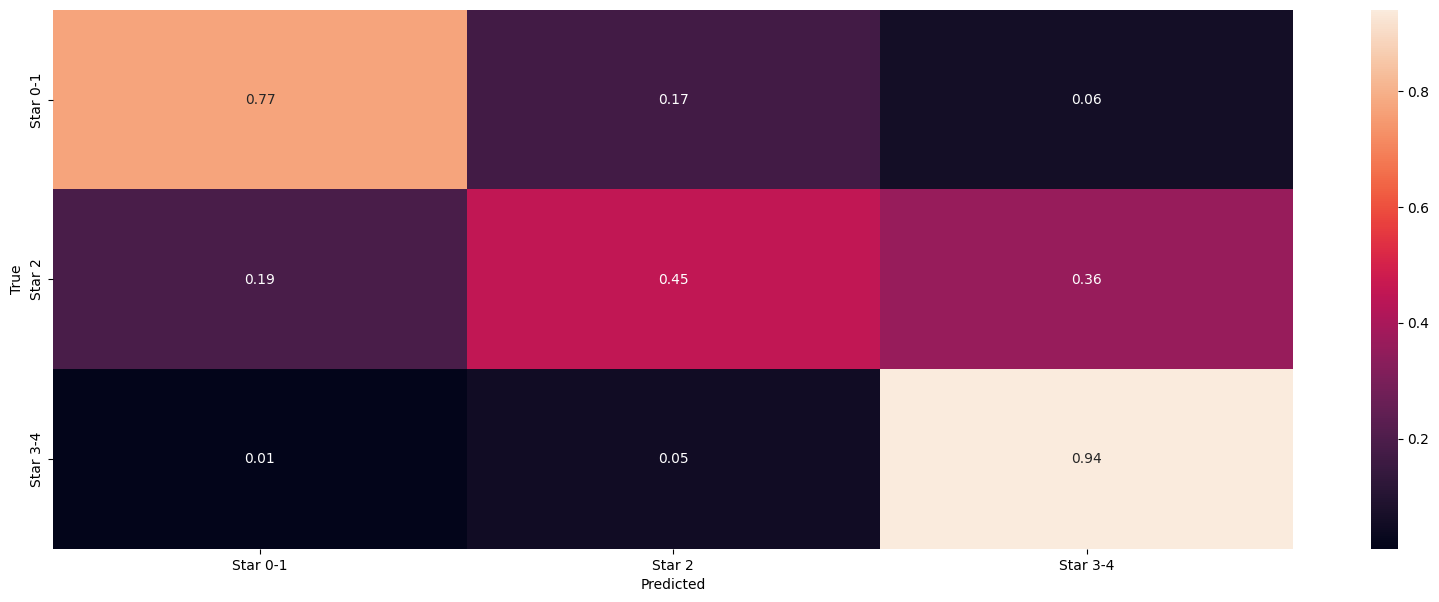

In [8]:
# score = pooler_roberta_model.evaluate([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask],test_labels)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
roberta_predictions_model = pooler_roberta_model.predict([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask])
roberta_predictions_model = tf.argmax(roberta_predictions_model, axis=-1)
print(classification_report(test_labels, roberta_predictions_model.numpy(), target_names=["Star 0-1","Star 2","Star 3-4"]))
# confusion matrix
cm = tf.math.confusion_matrix(test_labels, roberta_predictions_model)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0-1","Star 2","Star 3-4"],
    yticklabels=["Star 0-1","Star 2","Star 3-4"])
plt.xlabel("Predicted")
plt.ylabel("True")

## DeBERTa-base

In [9]:
### Hyperparams for debterta
num_classes = 3
hidden_size = 200
dropout = 0.2
learning_rate = 1e-5
max_length = 200
epoch = 3

In [10]:
# tokenization
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

model_checkpoint = 'microsoft/deberta-base'

deberta_tokenizer = DebertaTokenizer.from_pretrained(model_checkpoint)
deberta_model = TFDebertaModel.from_pretrained(model_checkpoint)

deberta_train_encodings = deberta_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
deberta_test_encodings = deberta_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
nptest_labels = np.asarray(test_labels)

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


In [11]:
def create_deberta_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 5,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                 max_length = 128):

    # Input Preparations
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask}

    # Bert
    bert_out = deberta_model(bert_inputs, output_hidden_states=True)

    # Pooler Token
    pooler_token = bert_out.hidden_states[-1]
    pooler_token = pooler_token[:,0]

    # Hidden Layers
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Classification Layers
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                metrics='accuracy')

    return classification_model

In [12]:
pooler_deberta_model = create_deberta_multiclass_model(checkpoint=model_checkpoint, num_classes=num_classes,hidden_size=hidden_size,dropout=dropout,learning_rate=learning_rate,max_length=max_length)
# pooler_deberta_model.summary()
# training
pooler_deberta_model_history = pooler_deberta_model.fit([deberta_train_encodings.input_ids, deberta_train_encodings.token_type_ids, deberta_train_encodings.attention_mask],
                                        train_labels,
                                        validation_data=([deberta_test_encodings.input_ids, deberta_test_encodings.token_type_ids, deberta_test_encodings.attention_mask],
                                        nptest_labels),
                                        batch_size=30,
                                        epochs=epoch)

Epoch 1/3


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


57/57 [==============================] - 189s 2s/step - loss: 1.0572 - accuracy: 0.4582 - val_loss: 0.6979 - val_accuracy: 0.7000
Epoch 2/3
57/57 [==============================] - 110s 2s/step - loss: 0.5532 - accuracy: 0.7735 - val_loss: 0.5714 - val_accuracy: 0.7733
Epoch 3/3
57/57 [==============================] - 109s 2s/step - loss: 0.3705 - accuracy: 0.8565 - val_loss: 0.5824 - val_accuracy: 0.7933


10/10 [==============================] - 18s 511ms/step
              precision    recall  f1-score   support

    Star 0-1       0.83      0.86      0.85       100
      Star 2       0.76      0.58      0.66       100
    Star 3-4       0.78      0.94      0.85       100

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



Text(220.72222222222223, 0.5, 'True')

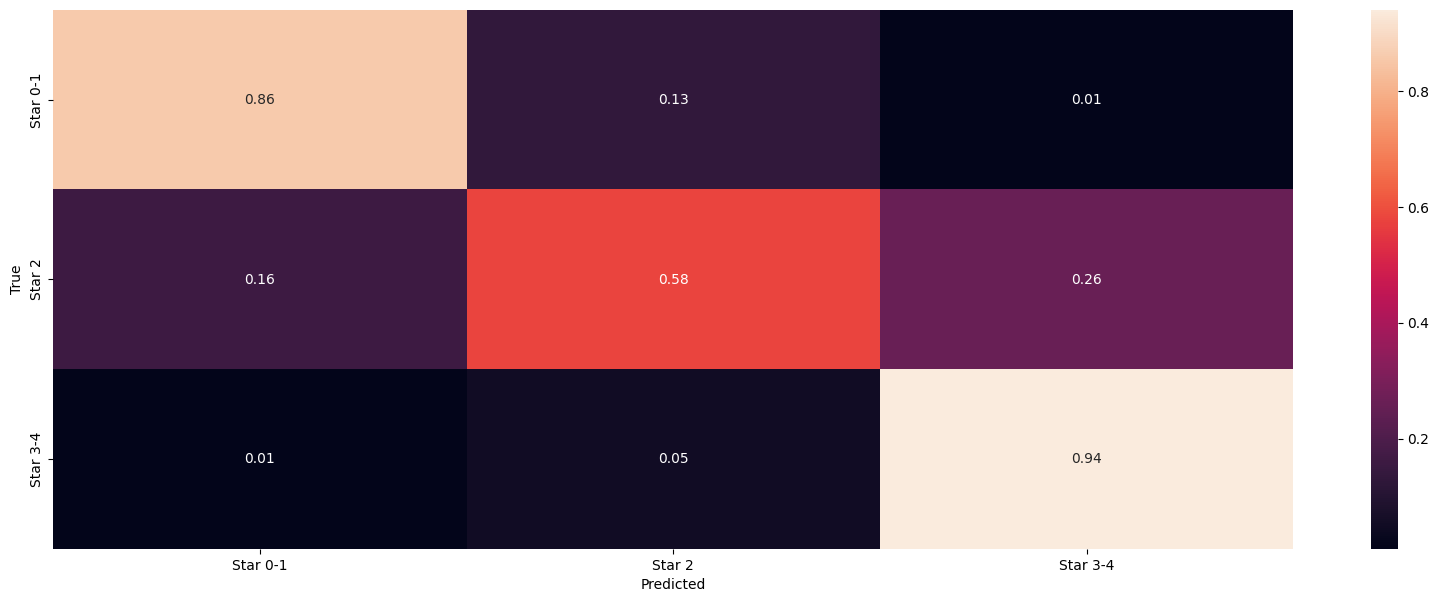

In [13]:
deberta_predictions_model = pooler_deberta_model.predict([deberta_test_encodings.input_ids, deberta_test_encodings.token_type_ids, deberta_test_encodings.attention_mask])
deberta_predictions_model = tf.argmax(deberta_predictions_model, axis=-1)
print(classification_report(test_labels, deberta_predictions_model.numpy(), target_names=["Star 0-1","Star 2","Star 3-4"]))
# confusion matrix
cm = tf.math.confusion_matrix(test_labels, deberta_predictions_model)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0-1","Star 2","Star 3-4"],
    yticklabels=["Star 0-1","Star 2","Star 3-4"])
plt.xlabel("Predicted")
plt.ylabel("True")


## Ensemble Learning

In [14]:
roberta_predictions_model = pooler_roberta_model.predict([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask])
deberta_predictions_model = pooler_deberta_model.predict([deberta_test_encodings.input_ids, deberta_test_encodings.token_type_ids, deberta_test_encodings.attention_mask])

10/10 [==============================] - 5s 519ms/step


### 1.0 Ensemble Learning - Averaging

In [15]:
avg_pred = (roberta_predictions_model + deberta_predictions_model)/2
avg_pred = np.argmax(avg_pred, axis=1)
print(classification_report(test_labels, avg_pred, target_names=["Star 0-1","Star 2","Star 3-4"]))

np.save("avg_pred.npy",avg_pred)

              precision    recall  f1-score   support

    Star 0-1       0.83      0.84      0.84       100
      Star 2       0.75      0.49      0.59       100
    Star 3-4       0.70      0.94      0.80       100

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.74       300
weighted avg       0.76      0.76      0.74       300



Text(220.72222222222223, 0.5, 'True')

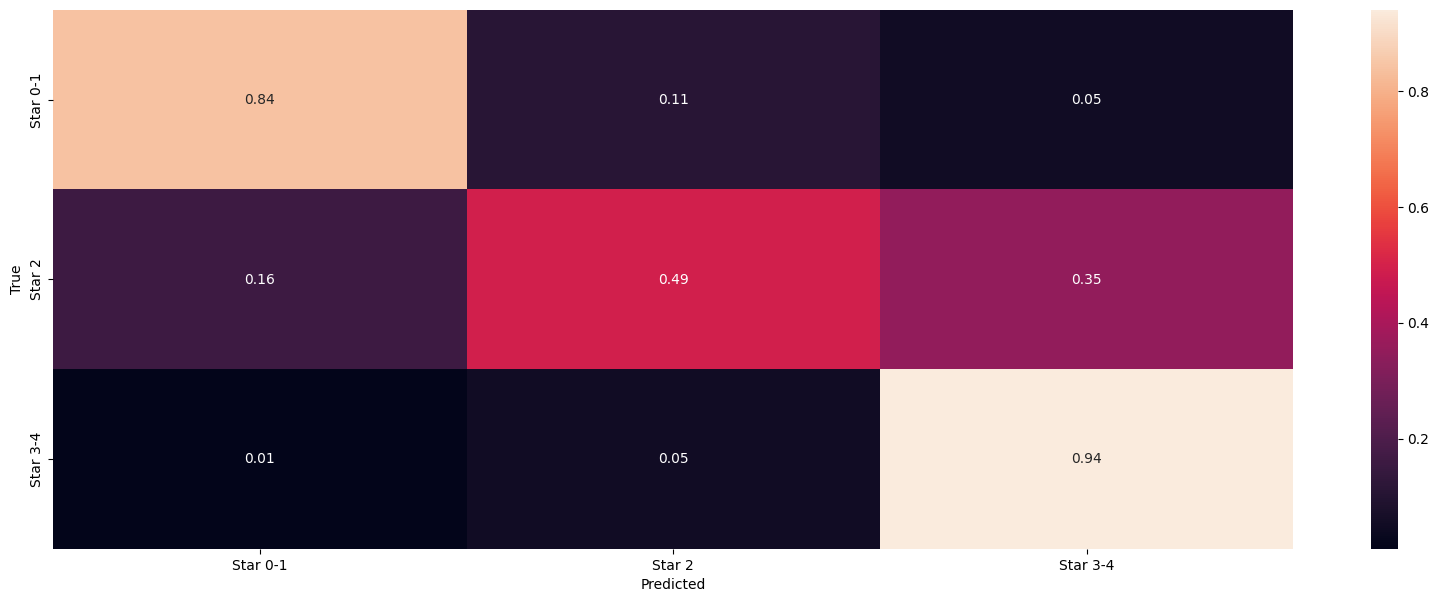

In [16]:
cm = tf.math.confusion_matrix(test_labels, avg_pred)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0-1","Star 2","Star 3-4"],
    yticklabels=["Star 0-1","Star 2","Star 3-4"])
plt.xlabel("Predicted")
plt.ylabel("True")

In [17]:
roberta_training = pooler_roberta_model.predict([roberta_train_encodings.input_ids, roberta_train_encodings.attention_mask])
deberta_training = pooler_deberta_model.predict([deberta_train_encodings.input_ids, deberta_train_encodings.token_type_ids, deberta_train_encodings.attention_mask])

roberta_predictions_model = pooler_roberta_model.predict([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask])
deberta_predictions_model = pooler_deberta_model.predict([deberta_test_encodings.input_ids, deberta_test_encodings.token_type_ids, deberta_test_encodings.attention_mask])

train_x = (roberta_training + deberta_training)/2
train_y = train_labels


test_x = (roberta_predictions_model + deberta_predictions_model)/2
test_y = test_labels

10/10 [==============================] - 5s 515ms/step


### 2.0 Random Forest

In [18]:
import joblib

              precision    recall  f1-score   support

    Star 0-1       0.81      0.85      0.83       100
      Star 2       0.71      0.55      0.62       100
    Star 3-4       0.77      0.91      0.83       100

    accuracy                           0.77       300
   macro avg       0.76      0.77      0.76       300
weighted avg       0.76      0.77      0.76       300



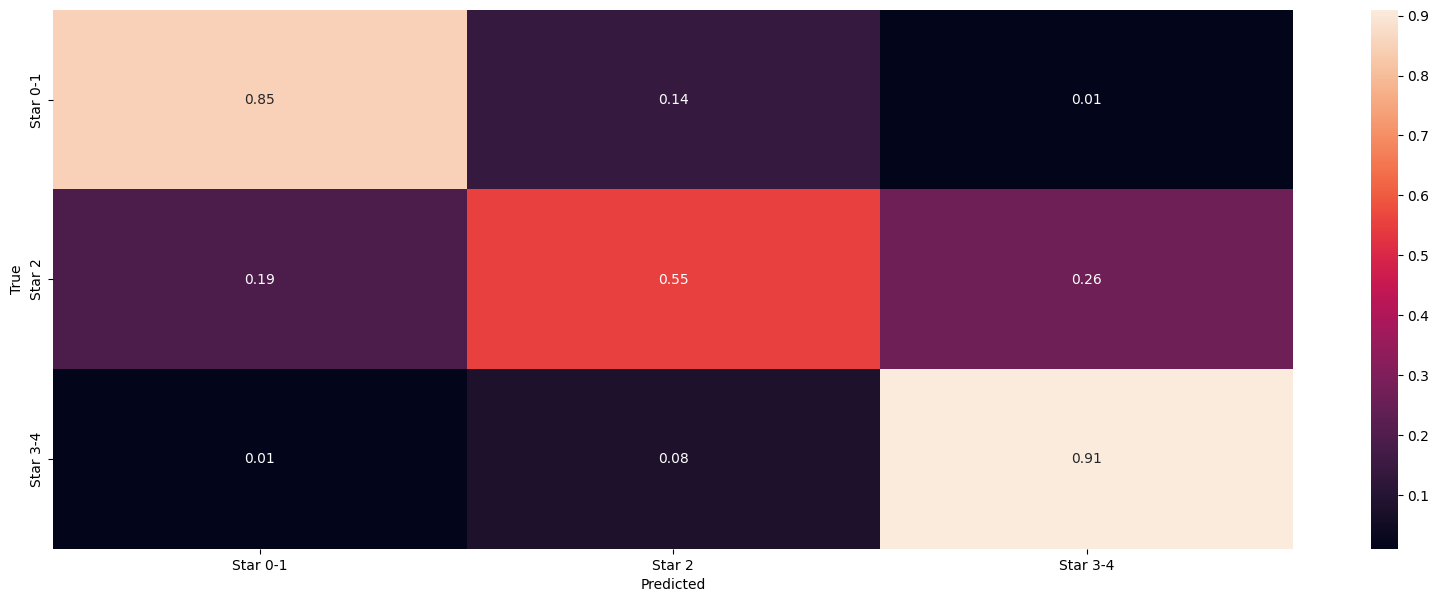

In [19]:
rf_es = RandomForestClassifier(max_depth=2, random_state=0)
rf_es.fit(train_x, train_y)
rf_output = rf_es.predict(test_x)
print(classification_report(test_y, rf_output, target_names=["Star 0-1","Star 2","Star 3-4"]))

cm = tf.math.confusion_matrix(test_y, rf_output)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0-1","Star 2","Star 3-4"],
    yticklabels=["Star 0-1","Star 2","Star 3-4"])
plt.xlabel("Predicted")
plt.ylabel("True")

joblib.dump(rf_es,"random_forest_classifer.pkl")
np.save("random_forest_pred.npy",rf_output)

###3.0 Decision Tree

              precision    recall  f1-score   support

    Star 0-1       0.78      0.89      0.83       100
      Star 2       0.76      0.50      0.60       100
    Star 3-4       0.78      0.93      0.85       100

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.76       300
weighted avg       0.77      0.77      0.76       300



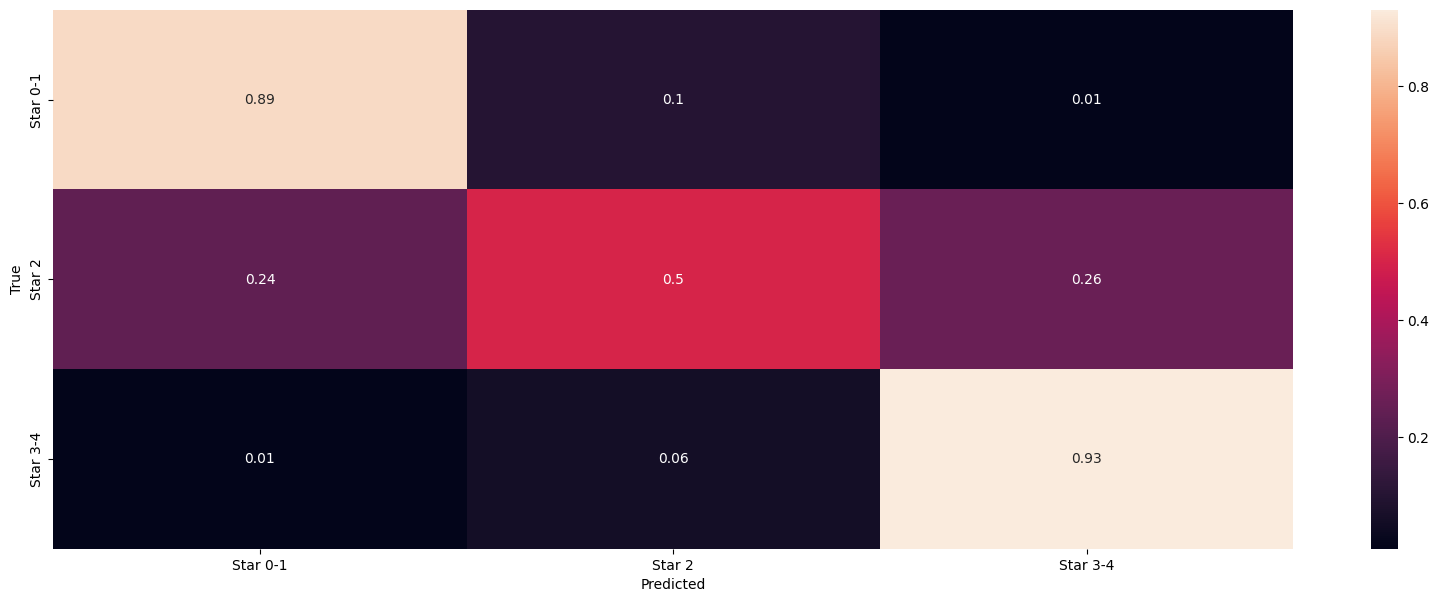

In [20]:
rf_es = DecisionTreeClassifier(random_state=0, max_depth=3)
rf_es.fit(train_x, train_y)
rf_output = rf_es.predict(test_x)
print(classification_report(test_y, rf_output, target_names=["Star 0-1","Star 2","Star 3-4"]))

cm = tf.math.confusion_matrix(test_y, rf_output)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0-1","Star 2","Star 3-4"],
    yticklabels=["Star 0-1","Star 2","Star 3-4"])
plt.xlabel("Predicted")
plt.ylabel("True")

joblib.dump(rf_es,"decision_tree_classifer.pkl")
np.save("decision_tree_pred.npy",rf_output)

###4.0 MLP

              precision    recall  f1-score   support

    Star 0-1       0.78      0.87      0.82       100
      Star 2       0.73      0.57      0.64       100
    Star 3-4       0.82      0.90      0.86       100

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.77       300
weighted avg       0.78      0.78      0.77       300



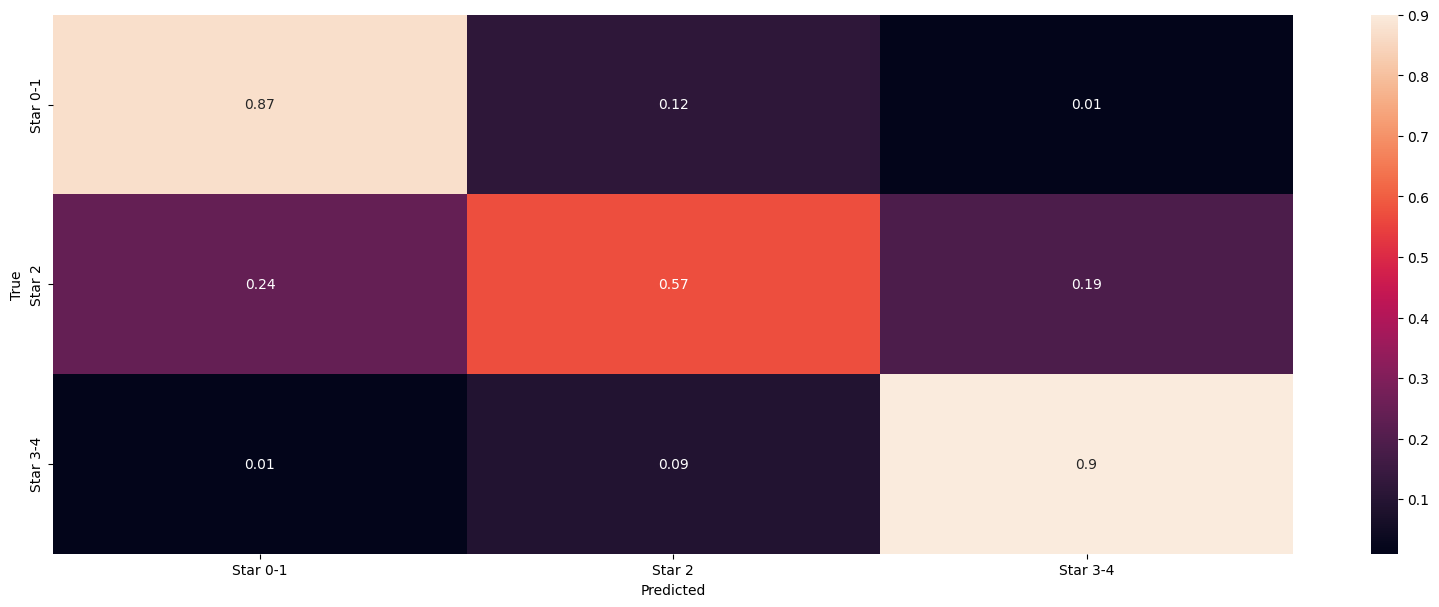

In [21]:
rf_es = MLPClassifier(random_state=1, max_iter=500, learning_rate_init=0.005)
rf_es.fit(train_x, train_y)
rf_output = rf_es.predict(test_x)
print(classification_report(test_y, rf_output, target_names=["Star 0-1","Star 2","Star 3-4"]))

cm = tf.math.confusion_matrix(test_y, rf_output)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0-1","Star 2","Star 3-4"],
    yticklabels=["Star 0-1","Star 2","Star 3-4"])
plt.xlabel("Predicted")
plt.ylabel("True")

joblib.dump(rf_es,"mlp_classifer.pkl")
np.save("mlp_pred.npy",rf_output)

###5.0 Gradient Boosting

              precision    recall  f1-score   support

    Star 0-1       0.78      0.89      0.83       100
      Star 2       0.76      0.50      0.60       100
    Star 3-4       0.78      0.93      0.85       100

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.76       300
weighted avg       0.77      0.77      0.76       300



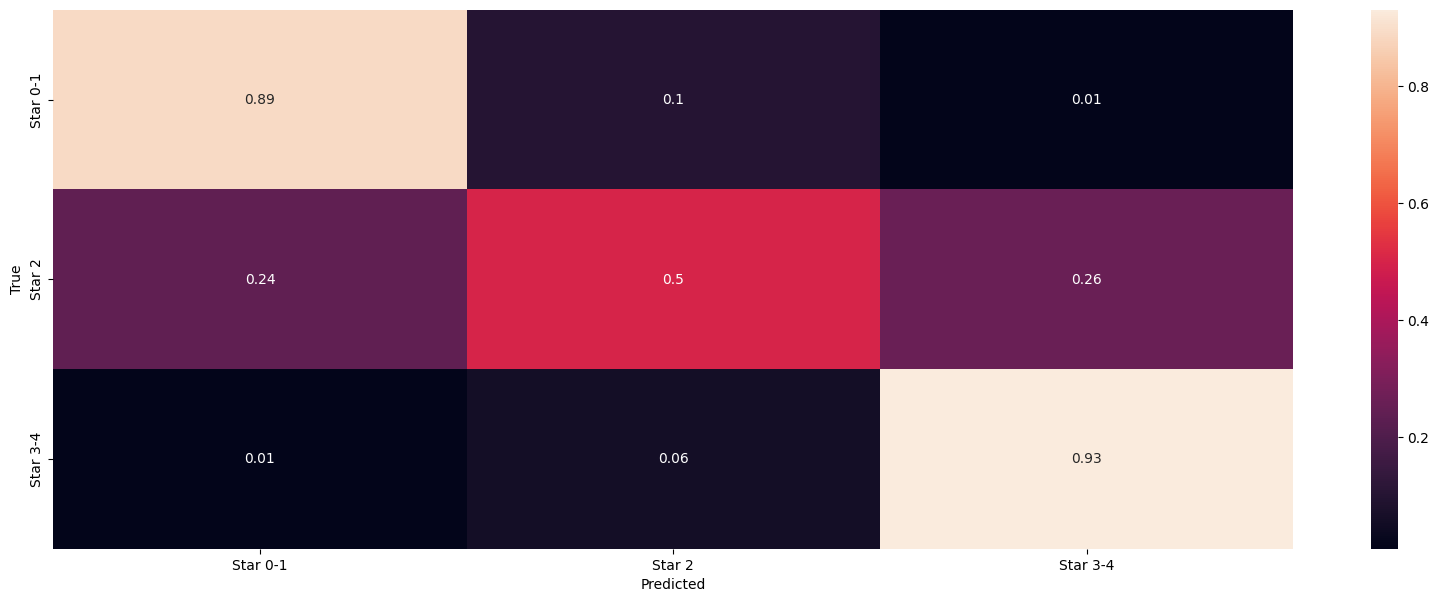

In [22]:
rf_es = GradientBoostingClassifier(n_estimators=200, learning_rate=0.005,
    max_depth=1, random_state=0)
rf_es.fit(train_x, train_y)
rf_output = rf_es.predict(test_x)
print(classification_report(test_y, rf_output, target_names=["Star 0-1","Star 2","Star 3-4"]))

cm = tf.math.confusion_matrix(test_y, rf_output)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0-1","Star 2","Star 3-4"],
    yticklabels=["Star 0-1","Star 2","Star 3-4"])
plt.xlabel("Predicted")
plt.ylabel("True")

joblib.dump(rf_es,"gb_classifer.pkl")
np.save("gb_pred.npy",rf_output)

###6.0 Stacking

              precision    recall  f1-score   support

    Star 0-1       0.85      0.83      0.84       100
      Star 2       0.72      0.63      0.67       100
    Star 3-4       0.79      0.90      0.84       100

    accuracy                           0.79       300
   macro avg       0.78      0.79      0.78       300
weighted avg       0.78      0.79      0.78       300



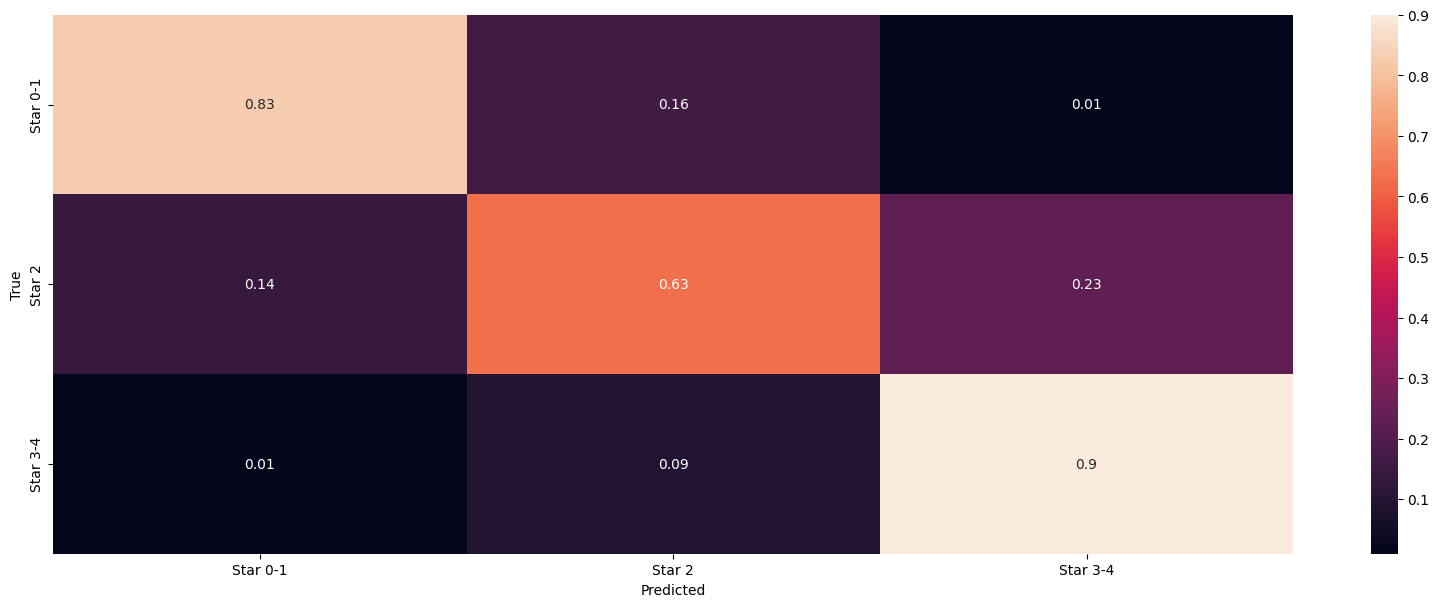

In [23]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('mlp', MLPClassifier(random_state=1, max_iter=500, learning_rate_init=0.005)),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.005,
    max_depth=1, random_state=0))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=DecisionTreeClassifier()
)

clf.fit(train_x, train_y)
rf_output = clf.predict(test_x)
print(classification_report(test_y, rf_output, target_names=["Star 0-1","Star 2","Star 3-4"]))

cm = tf.math.confusion_matrix(test_y, rf_output)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0-1","Star 2","Star 3-4"],
    yticklabels=["Star 0-1","Star 2","Star 3-4"])
plt.xlabel("Predicted")
plt.ylabel("True")

joblib.dump(rf_es,"stacking_classifer.pkl")
np.save("stacking_pred.npy",rf_output)

###7.0 Voting

              precision    recall  f1-score   support

    Star 0-1       0.77      0.89      0.83       100
      Star 2       0.78      0.56      0.65       100
    Star 3-4       0.81      0.92      0.86       100

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.78       300
weighted avg       0.79      0.79      0.78       300



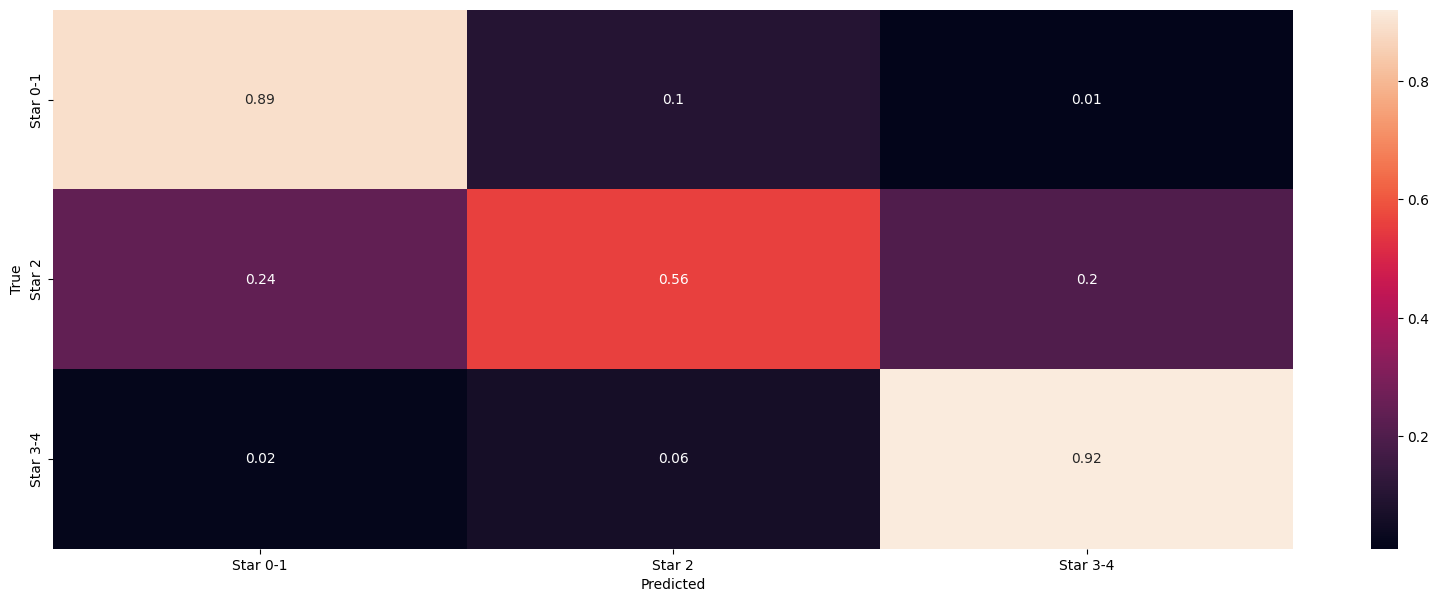

In [24]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('mlp', MLPClassifier(random_state=1, max_iter=500, learning_rate_init=0.005)),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.005,
    max_depth=1, random_state=0))
]

clf = VotingClassifier(
    estimators=estimators, voting='hard'
)

clf.fit(train_x, train_y)
rf_output = clf.predict(test_x)
print(classification_report(test_y, rf_output, target_names=["Star 0-1","Star 2","Star 3-4"]))

cm = tf.math.confusion_matrix(test_y, rf_output)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0-1","Star 2","Star 3-4"],
    yticklabels=["Star 0-1","Star 2","Star 3-4"])
plt.xlabel("Predicted")
plt.ylabel("True")

joblib.dump(rf_es,"voting_classifer.pkl")
np.save("voting_pred.npy",rf_output)

In [25]:
## Save the Prediction results
np.save('roberta_pred.npy',np.argmax(roberta_predictions_model, axis=1))
np.save('deverta_pred.npy',np.argmax(deberta_predictions_model, axis=1))

## Save Models locally

In [26]:
# ## == save the model to local disk
# pooler_roberta_model.save("roberta_base.h5")
# pooler_deberta_model.save("deberta_base.h5")

In [27]:
# categories = ['Averaging', 'RR', 'DT', 'MLP','GB','Stacking','Voting']
# subcategory1 = [0.59, 0.62, 0.61, 0.62, 0.58, 0.55, 0.60]
# subcategory2 = [0.59, 0.62, 0.61, 0.62, 0.58, 0.55, 0.61]

# x = np.arange(len(categories))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()

# rects1 = ax.bar(x - width/2, subcategory1, width, label='Micro F1', color = "darkcyan")
# rects2 = ax.bar(x + width/2, subcategory2, width, label='Macro F1', color = "salmon")

# # 添加一些文本标签
# ax.set_xlabel('Ensemble Learning Approach')
# ax.set_ylabel('Metric Values')
# ax.set_xticks(x)
# ax.set_xticklabels(categories, rotation = 0)
# ax.legend(loc = 'best')